In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc, mean_squared_error
from sklearn.metrics import roc_auc_score
mse = mean_squared_error

TRAIN_FNAME = "training_data_tabular_format.csv"
TEST_FNAME = "test_data_tabular_format.csv"

from pprint import pprint
pdd = lambda x: pprint(dir(x))
pt = lambda x: print(type(x))

import beepy
BEEP = lambda: beepy.beep()

In [2]:
from functools import reduce
def call(f, **fkwargs):
    def g(*args, **gkwargs):
        gkwargs.update(fkwargs)
        return f(*args, **gkwargs)
    return g


dftype = pd.core.frame.DataFrame

def encode(df):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(df)
    arr = enc.transform(df).toarray()
    return arr

DROP_COLUMNS = [
    "version", 
    "players.0.ai", 
    "players.1.ai", 
    "id", 
    "players.1.player_id", 
    "players.0.player_id",
]

In [3]:
DATA_LEN = 10000
PREP_TRAIN_STEPS = [
    call(dftype.drop, axis=1, labels=DROP_COLUMNS),
#     call(dftype.sample, n=DATA_LEN),
    call(dftype.fillna, value=-1),
    call(dftype.dropna, axis="columns"),
    pd.get_dummies,
#     encode,
]

PREP_TEST_STEPS = PREP_TRAIN_STEPS

Y_COLNAME = "winner"

def split_train(df, ycolname=Y_COLNAME):
    y = df[ycolname]
    df.drop(ycolname, axis=1, inplace=True)
    x = df
    return df, y

def preprocess(df, step_fns, const_len=False):
    if not const_len:
        return reduce(lambda df, f: f(df), step_fns, df)
    else:
        for i, f in enumerate(step_fns):
            df_copy = df.copy()
            df = f(df)
            prev, cur = df_copy.shape[0], df.shape[0]
            if (prev != cur):
                print(f"Skipping function {i}, as it would change len from {prev} to {cur}")
                df = df_copy
                continue
        return df

def preprocess_train(df):
    return preprocess(df, PREP_TRAIN_STEPS)

def preprocess_test(df, train_df):
    return preprocess(df, PREP_TEST_STEPS, const_len=True)

def get_datasets(train_df, test_df):
    X_train = preprocess_train(train_df)
    X_test = preprocess_test(test_df, X_train)
    
    X_train, Y = split_train(X_train)
    
    common_columns = X_train.columns.intersection(X_test.columns)
    X_train = X_train[common_columns]
    X_test = X_test[common_columns]
    
    assert all([x == y for x, y in zip(X_train.columns, X_test.columns)])
    
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

#     scoring_data = scaler.transform(scoring_data)
#     pt(scoring_data)
# np.isnan(X_train).any()
    
    return X_train, Y, X_test
    

X_train, Y_train, X_test = get_datasets(pd.read_csv(TRAIN_FNAME), pd.read_csv(TEST_FNAME))

print(X_train.shape, Y_train.shape, X_test.shape)

(38658, 1721) (38658,) (20000, 1721)


In [295]:
XT, XV, YT, YV = train_test_split(X_train,Y_train,test_size=0.1,random_state=43)

In [202]:
# X_transformed
XT, XV, YT, YV = train_test_split(whitened,Y_train,test_size=0.3,random_state=42)

In [198]:
from sklearn.decomposition import FastICA, PCA

pca = PCA(n_components=300, whiten=True)
whitened = pca.fit_transform(X_train)
print(whitened.shape)
    
# transformer = FastICA(
#     n_components=None,
#     random_state=42,
#     algorithm='parallel', 
#     whiten=True, 
#     fun='logcosh', 
#     fun_args=None, 
#     max_iter=400, 
#     tol=0.001, 
#     w_init=None, 
# )
# X_transformed = transformer.fit_transform(X_train)
# X_transformed.shape
BEEP()

(10000, 300)


In [218]:
from xgboost import XGBClassifier
model = XGBClassifier(
    verbosity=1,
    n_estimators=200,
    eval_metric="error",
    max_depth=3,
    gamma=0.5,
#     min_child_weight=111,
#     max_delta_step=111,
#     subsample=111,
)
# model.score
model.fit(XT, YT)
model.score(XV, YV)
from sklearn.metrics import roc_auc_score
roc_auc_score(YV, model.predict_proba(XV)[:,1])

/home/mateusz/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8528551726468245

Accuracy: 78.81%


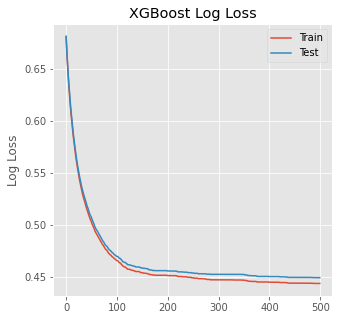

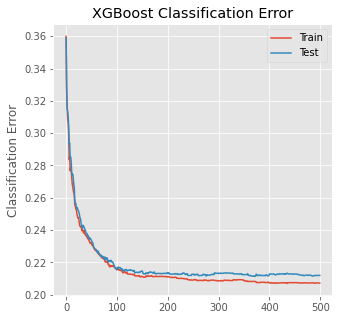

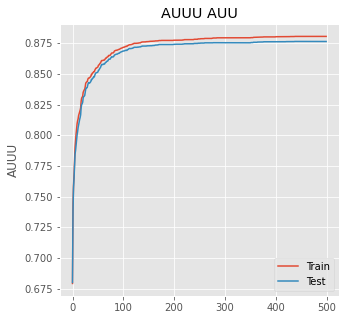

In [12]:

import warnings
warnings.filterwarnings("ignore")

# load libraries
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import matplotlib.pyplot as plt    

plt.style.use('ggplot')    

# split data into train and test sets
XT, XV, YT, YV = train_test_split(X_train,Y_train,test_size=0.3,random_state=42321)

# fit model no training data
model = XGBClassifier(
    verbosity=1,
    learning_rate=0.1,
    n_estimators=500,
#     eval_metric="error",
    max_depth=3,
    subsample=0.5,
    min_child_weight=75,
    gamma=25,
#     reg_lambda=20,
#     max_delta_step=10,
)

eval_set = [(XT, YT), (XV, YV)]
model.fit(XT, YT, eval_metric=["error", "logloss", "auc"], eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(XV)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(YV, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()

pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()


# plot classification error
fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

fig, ax = pyplot.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUUU')
pyplot.title('AUUU AUU')
pyplot.show()


BEEP()

In [13]:
print(model.score(XV, YV))
print(roc_auc_score(YV, model.predict_proba(XV)[:,1]))

0.7880669080876013
0.8763612407790513


In [205]:
n_features = 50 # "sqrt"
model = GradientBoostingClassifier(
    random_state=43,
    verbose=1,
    
    n_estimators=500,
    learning_rate=0.1,
    max_depth=3,
    max_features=n_features,
#     min_samples_split=0.5,
    min_samples_leaf=0.15,
#     subsample = 0.8,
    
).fit(XT, YT)
# ).fit(X_train, Y_train)
print(model)

model.score(XV, YV)

      Iter       Train Loss   Remaining Time 
         1           1.3591            1.05m
         2           1.3423           52.82s
         3           1.3176           51.21s
         4           1.2883           48.11s
         5           1.2691           48.00s
         6           1.2667           49.58s
         7           1.2649           56.33s
         8           1.2507           55.75s
         9           1.2487           53.77s
        10           1.2463           55.14s
        20           1.1724           48.98s
        30           1.1162           45.35s
        40           1.0767           43.30s
        50           1.0445           42.27s
        60           1.0209           40.87s
        70           0.9964           39.55s
        80           0.9795           38.45s
        90           0.9674           37.36s
       100           0.9576           36.33s
       200           0.8757           27.04s
       300           0.8212           17.87s
       40

0.7423333333333333

In [196]:
roc_auc_score(YV, model.predict_proba(XV)[:,1])

0.8190207454414808

In [10]:
def dump_model(m):
    params = [
        "n_estimators", 
        "learning_rate", 
        "max_depth", 
        "max_features", 
        "min_samples_split",
        "min_samples_leaf"
    ]
    res_str = "xgboost_python_"
    if isinstance(m, XGBClassifier):
        params = [
            "learning_rate",
            "max_depth",
            "subsample",
            "min_child_weight",
            "gamma",
        ]
        res_str = "STAN_real_xgb_"
    short = lambda param: "".join([ s[0] for s in param.split('_') ])
    for p in params:
        k = short(p)
        v = getattr(model, p)
        res_str += f"_{k}{v}"
    try:
        score = model.score(XV, YV)
        res_str += f"_score{round(score, 3)}"
    except:
        pass
    res_str += ".txt"
    return res_str

dump_model(model)

'STAN_real_xgb__lr0.1_md2_s0.5_mcw75_g25_score0.789.txt'

In [11]:
def predict(xv, store=False, fname=dump_model(model)):
    res = model.predict_proba(xv)[:,1]
    if store:
        np.savetxt(fname, res, fmt="%.5f")
        print(f"File \n   {fname}\nsaved successfully!")
    return res

res = predict(X_test, store=True)
print(res.shape)


File 
   STAN_real_xgb__lr0.1_md2_s0.5_mcw75_g25_score0.789.txt
saved successfully!
(20000,)


In [227]:
def compare(res, fname="glmnet_full.txt"):
    snd = np.loadtxt(fname)
    err = mse(res, snd)
    return err

compare(res, fname="xgboost_full.txt")

0.03269997131904032